In [10]:
import spacy
from spacy.matcher import Matcher
import re
from datetime import datetime
from spacy.matcher import PhraseMatcher
from skillNer.general_params import SKILL_DB
from skillNer.skill_extractor_class import SkillExtractor
from spacy import displacy
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from dateparser.search import search_dates
import pandas as pd
from spacy.lang.en.stop_words import STOP_WORDS
from string import punctuation
from tabulate import tabulate
from collections import defaultdict
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import fitz  # PyMuPDF
import warnings

# Ignore warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Initialize stop words
stop_words = STOP_WORDS

# Load spaCy model
nlp = spacy.load('en_core_web_lg')
matcher = Matcher(nlp.vocab)


In [11]:
# Path to resume file
resume_path = r"C:\Users\khmir\Downloads\khmiri_iheb_tun_eng.pdf"

# Extracting text from PDF using PyMuPDF
with fitz.open(resume_path) as doc:
    cc = ""
    for page in doc:
        cc += page.get_text()

# Process the text with spaCy
doc = nlp(cc)

# Print the first 1000 characters of the processed text (you can adjust the size)
print(doc[:1000])


IHEB KHMIRI
Profile Summary
Soon-to-be graduate in Computer
Engineering with a specialization
in Business Intelligence,
passionate about data analysis
and Big Data processing. I am
looking for my first professional
experience to deepen my skills
and contribute to innovative
projects in this field.
Contact
@ khmiri.iheb@esprit.tn
H +216 29 118 233
° khmiri iheb
 ihebkh
 khmiri iheb
Skills
• Web Development: .NET Core,
Spring Boot, Angular, Next.js,
FastAPI, Django, React.js
• Data Integration: SSIS, SSAS,
Talend, Microsoft Power BI,
Python
• DevOps: Docker, JUnit,
Mockito, SonarQube, Nexus,
Grafana, Prometheus
• Databases: SSMS, Oracle,
PostgreSQL
• Big Data: Spark, Hadoop,
Kafka, MongoDB,
Elasticsearch
Languages
• Arabic: Native language
• French: B2
• English: B2
PROFESSIONAL EXPERIENCE
DigitalCook Tunisia
End-of-studies Project
February 2025 – August 2025
• Requirements gathering and system design.
• Development of data integration and ETL processes.
• Design, testing, and integrat

In [12]:
# Define various date patterns
date_patterns = [
    [{"TEXT": {"regex": r"\b\d{1,2}[/-]\d{1,2}[/-]\d{4}\b"}}],  # MM/DD/YYYY, MM-DD-YYYY, or MM.DD.YYYY
    [{"TEXT": {"regex": r"(?:Jan(?:uary)?|Feb(?:ruary)?|Mar(?:ch)?|Apr(?:il)?|May|Jun(?:e)?|Jul(?:y)?|Aug(?:ust)?|Sep(?:tember)?|Oct(?:ober)?|Nov(?:ember)?|Dec(?:ember)?)"}, "OP": "?"}, 
      {"TEXT": ",", "OP": "?"}, 
      {"IS_DIGIT": True, "OP": "?"}, 
      {"TEXT": {"regex": r"\d{4}"}}],  # Month Day, Year format (e.g., Jan 2020)
    [{"TEXT": {"regex": r"(?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)\s+\d{4}"}}],  # Month Year (e.g., Jan 2020)
    [{"TEXT": {"regex": r"\b\d{4}\b"}}],  # Year only (e.g., 2020)
    [{"TEXT": {"regex": r"\b\d{1,2}[/-]\d{4}\b"}}],  # Month-Year format (e.g., 12/2020 or 12-2020)
    [{"TEXT": {"regex": r"(?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)\s+\d{1,2}"}}]  # Month-Day format (e.g., Jan 5)
]

# Add the date patterns to the matcher
for pattern in date_patterns:
    matcher.add("DATE_PATTERN", [pattern], on_match=None)

# Apply the matcher to the document
matches = matcher(doc)

# Extract matched date patterns and print
matched_dates = []
for match_id, start, end in matches:
    span = doc[start:end]  # Get the matched span of text
    matched_dates.append(span.text)

# Display the matched dates
print("Matched Dates:", matched_dates)


Matched Dates: ['February 2025', '2025', 'August 2025', '2025', 'June 2024', '2024', 'August 2024', '2024', 'January 2024', '2024', 'June 2024', '2024', 'September 2020', '2020', 'September 2019', '2019', 'July 2020', '2020', 'October 2024', '2024', 'September 2024', '2024', 'August 2024', '2024']


In [13]:
# Function to calculate total years of experience in months
def calculate_total_experience_in_months(resume_path):
    # Extracting text from PDF again
    with fitz.open(resume_path) as doc:
        cc = ""
        for page in doc:
            cc += page.get_text()

    lines = cc.splitlines()
    printed_lines = set()
    total_months = 0

    # Loop through each line and try to calculate the experience
    for line in lines:
        line = line.lower()
        line = re.sub(r"\b(months?|years?|mos|yr|yrs|mois|an|ans)\b", "", line, flags=re.IGNORECASE)
        line = line.replace(".", " ") 
        line = line.replace("present", datetime.now().strftime("%b %d, %Y"))
        line = line.replace("today", datetime.now().strftime("%b %d, %Y"))
        line = line.replace("now", datetime.now().strftime("%b %d, %Y"))
        line = line.replace("aujourd'hui", datetime.now().strftime("%b %d, %Y"))

        # Process each line with spaCy
        doc = nlp(line)
        parsed_date = search_dates(line, languages=["fr", "en"])

        if parsed_date is not None:
            parsed_date = [date[1] for date in parsed_date]

        for ent in doc.ents:
            if ent.label_ == "DATE" and line not in printed_lines:
                if parsed_date is not None and len(parsed_date) >= 2:
                    parsed_date.sort()
                    date1, date2 = parsed_date[:2]
                    diff_months = (date2.year - date1.year) * 12 + (date2.month - date1.month)
                    total_months += diff_months
                    printed_lines.add(line)

    # Convert total months to years and months
    years = total_months // 12
    months = total_months % 12
    return years, months

# Get total experience in years and months
years, months = calculate_total_experience_in_months(resume_path)
print(f"Total experience: {years} years and {months} months")


C:\Users\khmir\AppData\Local\Temp\ipykernel_16232\266823793.py:25: DeprecationWarning: Parsing dates involving a day of month without a year specified is ambiguious
and fails to parse leap day. The default behavior will change in Python 3.15
to either always raise an exception or to use a different default year (TBD).
To avoid trouble, add a specific year to the input & format.
See https://github.com/python/cpython/issues/70647.
  parsed_date = search_dates(line, languages=["fr", "en"])


Total experience: 6 years and 8 months


In [14]:
def display_token_info(doc):
    token_info = defaultdict(lambda: {"count": 0, "is_alpha": None, "is_digit": None, "is_punct": None, "is_stop": None,"is_blank_space": None ,"pos": None, "dep":None})

    for token in doc:
        token_text = token.text
        token_info[token_text]["count"] += 1
        if token_info[token_text]["is_alpha"] is None:
            token_info[token_text]["is_alpha"] = token.is_alpha
        if token_info[token_text]["is_digit"] is None:
            token_info[token_text]["is_digit"] = token.is_digit
        if token_info[token_text]["is_punct"] is None:
            token_info[token_text]["is_punct"] = token.is_punct
        if token_info[token_text]["is_stop"] is None:
            token_info[token_text]["is_stop"] = token.is_stop
        token_info[token_text]["is_blank_space"] = token_text.isspace()
        if token_info[token_text]["pos"] is None:
            token_info[token_text]["pos"] = token.pos_
        if token_info[token_text]["dep"] is None:
            token_info[token_text]["dep"] = token.dep_      
    # Combine duplicate blank space tokens into a single entry
    blank_space_tokens = [token_text for token_text in token_info if token_info[token_text]["is_blank_space"]]
    if blank_space_tokens:
        total_count = sum(token_info[token_text]["count"] for token_text in blank_space_tokens)
        first_token = blank_space_tokens[0]
        token_info[first_token]["count"] = total_count
        for token_text in blank_space_tokens[1:]:
            del token_info[token_text]

    stopwords = set([token.text for token in doc if token.is_stop])
    print(f"Stopwords: {stopwords}")
   
    table_headers = ["Token", "Occurrence", "Is Alpha", "Is Digit", "Is Punct", "Is Stop",  "Is Blank Space","POS","Dep"]
    table_data = [[token_text, info["count"], info["is_alpha"], info["is_digit"], info["is_punct"], info["is_stop"], info["is_blank_space"],info["pos"],info["dep"]] for token_text, info in token_info.items()]
    # tri descroissant par 2eme colonne occurence
    table_data.sort(key=lambda x: x[1], reverse=True)

    print(tabulate(table_data, headers=table_headers))

In [15]:
def before_data_cleaning(doc):
    length = len(doc)
    num_stopwords = len([token for token in doc if token.is_stop])
    num_blanks = sum(1 for token in doc if token.is_space)
    num_punctuations = len([token for token in doc if token.is_punct])
    num_digits = len([token for token in doc if token.is_digit])

    # Count number of email addresses
    emails = re.findall(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', doc.text)
    num_emails = len(emails)
 

    print("Before Data Cleaning:")
    print(f"Length of document: {length}")
    print(f"Number of stopwords: {num_stopwords}")
    print(f"Number of blank spaces: {num_blanks}")
    print(f"Number of punctuations: {num_punctuations}")
    print(f"Number of digits: {num_digits}")
    print(f"Number of email addresses: {num_emails}")
    display_token_info(doc)

before_data_cleaning(doc)

Before Data Cleaning:
Length of document: 552
Number of stopwords: 62
Number of blank spaces: 82
Number of punctuations: 124
Number of digits: 15
Number of email addresses: 1
Stopwords: {'first', 'in', 'a', 'from', 'them', 'I', 'and', 'an', 'through', 'for', 'this', 'to', 'the', 'into', 'my', 'with', 'about', 'using', 'be', 'am', 'of'}
Token                    Occurrence  Is Alpha    Is Digit    Is Punct    Is Stop    Is Blank Space    POS    Dep
---------------------  ------------  ----------  ----------  ----------  ---------  ----------------  -----  --------
                                 82  False       False       False       False      True              SPACE  dep
,                                53  False       False       True        False      False             PUNCT  punct
•                                25  False       False       True        False      False             VERB   prep
.                                16  False       False       True        False      False

In [16]:
skill_extractor = SkillExtractor(nlp, SKILL_DB, PhraseMatcher) 
def extract_skills(skill_extractor, cc):
    annotations = skill_extractor.annotate(cc)
    unique_values = set() 

    for item in annotations['results']['full_matches']:
        unique_values.add(item['doc_node_value'].lower())

    for item in annotations['results']['ngram_scored']:
        unique_values.add(item['doc_node_value'].lower())
    print(list(unique_values))
    return list(unique_values)



loading full_matcher ...
loading abv_matcher ...
loading full_uni_matcher ...
loading low_form_matcher ...
loading token_matcher ...


After Data Cleaning:
Length of document: 255
Number of stopwords: 0
Number of blank spaces: 0
Number of punctuations: 0
Number of digits: 0
Number of email addresses: 0
Stopwords: set()
Token             Occurrence  Is Alpha    Is Digit    Is Punct    Is Stop    Is Blank Space    POS    Dep
--------------  ------------  ----------  ----------  ----------  ---------  ----------------  -----  --------
integration                6  True        False       False       False      False             NOUN   compound
design                     6  True        False       False       False      False             NOUN   compound
data                       5  True        False       False       False      False             NOUN   compound
development                5  True        False       False       False      False             NOUN   nmod
business                   4  True        False       False       False      False             PROPN  compound
datum                      4  True        Fals

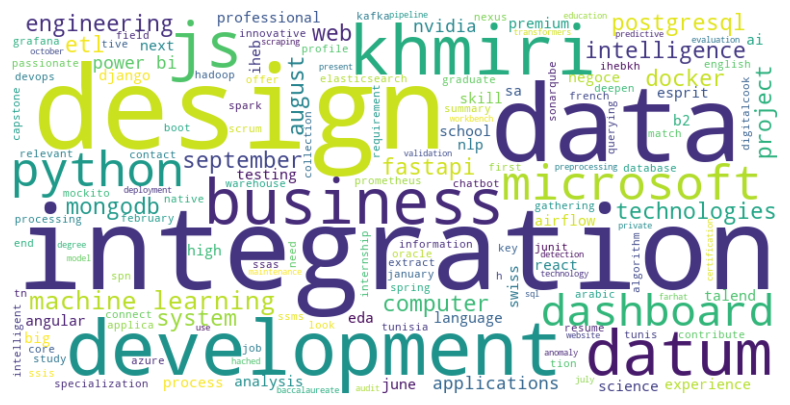

C:\Users\khmir\AppData\Local\Temp\ipykernel_16232\2750200711.py:63: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  bbar.set_yticklabels(bbar.get_yticklabels(), fontsize=10)


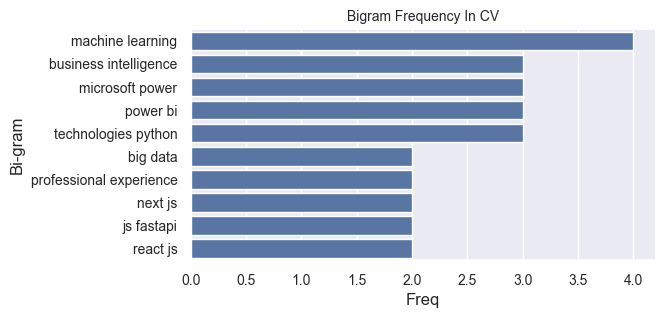

In [17]:
def get_top_n2_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(2,2),  
            max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]
def after_data_cleaning(doc):
    # Remove stopwords, punctuations, and digits
    cleaned_doc = [token for token in doc if token.text.strip().encode('utf-8').isalpha() and not token.is_stop and not token.is_punct and not token.is_digit and not token.is_space]

    length = len(cleaned_doc)
    num_stopwords = len([token for token in cleaned_doc if token.is_stop])
    num_blanks = sum(1 for token in cleaned_doc if token.is_space)
    num_punctuations = len([token for token in cleaned_doc if token.is_punct])
    num_digits = len([token for token in cleaned_doc if token.is_digit])


    cleaned_text = ' '.join([token.lemma_.lower() for token in cleaned_doc])

 
    emails = re.findall(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', cleaned_text)
    cleaned_text = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', '', cleaned_text)

    num_emails = len(emails)
    
    print("After Data Cleaning:")
    print(f"Length of document: {length}")
    print(f"Number of stopwords: {num_stopwords}")
    print(f"Number of blank spaces: {num_blanks}")
    print(f"Number of punctuations: {num_punctuations}")
    print(f"Number of digits: {num_digits}")
    print(f"Number of email addresses: {num_emails}")
    cleaned_doc = nlp(cleaned_text)
    display_token_info(cleaned_doc)
    # Generate word cloud
    filtered_text = " ".join([token.lemma_.lower() for token in doc if token.pos_ in [ 'PROPN', 'ADJ','VERB','NOUN'] and token not in stop_words ])
    unique_values_list = extract_skills(skill_extractor, cleaned_text)
    print(unique_values_list)
    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(filtered_text)

    # Display the word cloud using matplotlib
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
# Tokenize the filtered text
    top2_words = get_top_n2_words([filtered_text], n=len(filtered_text.split()))

    # Create a DataFrame from the top bi-grams
    top2_df = pd.DataFrame(top2_words)
    top2_df.columns = ["Bi-gram", "Freq"]

    # Create the bar plot for bi-grams
    sns.set(rc={'figure.figsize':(6,3)})
    bbar = sns.barplot(y="Bi-gram", x="Freq", orient='h', data=top2_df[:10])
    plt.title('Bigram Frequency In CV', size=10)
    plt.xticks(size=10)
    bbar.set_yticklabels(bbar.get_yticklabels(), fontsize=10)
    plt.show()
after_data_cleaning(doc)

In [18]:
def count_verbs(sentence):
    doc = nlp(sentence)
    verbs = len([token for token in doc if token.pos_ == 'VERB'])
    return verbs

def count_adjectives(sentence):
    doc = nlp(sentence)
    adjectives = len([token for token in doc if token.pos_ == 'ADJ'])
    return adjectives

def count_stopwords(sentence):
    doc = nlp(sentence)
    stopwords = len([token for token in doc if token.is_stop])
    return stopwords

def calculate_sentence_length(sentence):
    doc = nlp(sentence)
    sentence_length = len(doc)
    return sentence_length

def count_nouns(sentence):
    doc = nlp(sentence)
    nouns = len([token for token in doc if token.pos_ == 'NOUN'])
    return nouns

def count_special_characters(sentence):
    doc = nlp(sentence)
    special_chars = len([token for token in doc if not token.text.isalnum() and not token.is_punct])
    return special_chars

 

def count_skills(skill_extractor, sentence):
    doc = nlp(sentence)
    skills = len(extract_skills(skill_extractor, sentence))
    return skills

def count_punctuation(sentence):
    doc = nlp(sentence)
    punctuation_number = len([token for token in doc if token.is_punct])
    return punctuation_number

def count_digits(sentence):
    doc = nlp(sentence)
    digits_number = len([token for token in doc if token.is_digit])
    return digits_number

# Example usage:
input_sentence = "This is an example sentence with 5 verbs and 2 ETL sss  angular ssis adjectives."
print("Verbs:", count_verbs(input_sentence))
print("Adjectives:", count_adjectives(input_sentence))
print("Stopwords:", count_stopwords(input_sentence))
print("Sentence Length:", calculate_sentence_length(input_sentence))
print("Nouns:", count_nouns(input_sentence))
print("Special Characters:", count_special_characters(input_sentence))
# Assuming skill_extractor is defined somewhere
print("Skills:", count_skills(skill_extractor, input_sentence))
print("Punctuation Number:", count_punctuation(input_sentence))
print("Digits Number:", count_digits(input_sentence))

Verbs: 0
Adjectives: 1
Stopwords: 5
Sentence Length: 17
Nouns: 7
Special Characters: 1
['ssis', 'angular', 'etl']
Skills: 3
Punctuation Number: 1
Digits Number: 2


In [2]:
import pytesseract
from pdf2image import convert_from_path
import re
import spacy
from skillNer.skill_extractor_class import SkillExtractor
from spacy.matcher import PhraseMatcher
import json

# === Configuration
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"
CV_PATH = r"C:\Users\khmir\Downloads\khmiri_iheb_tun_eng.pdf"
SKILL_DB_PATH = r"C:\Users\khmir\Desktop\data-science\skill_db_relax_20.json"

# === Initialisation NLP et SkillExtractor
nlp = spacy.load('en_core_web_lg')
with open(SKILL_DB_PATH, 'r', encoding='utf-8') as f:
    SKILL_DB = json.load(f)
skill_extractor = SkillExtractor(nlp, SKILL_DB, PhraseMatcher)

# === Fonction : extraire texte via OCR
def extract_text_from_pdf(pdf_path):
    images = convert_from_path(pdf_path)
    full_text = ""
    for image in images:
        full_text += pytesseract.image_to_string(image, lang='eng+fra') + "\n"
    return re.sub(r"\s+", " ", full_text.strip())

# === Fonction : extraire les skills
def extract_skills_only(skill_extractor, text):
    annotations = skill_extractor.annotate(text)
    skills = set()
    for item in annotations['results']['full_matches']:
        skills.add(' '.join(dict.fromkeys(item['doc_node_value'].lower().split())))
    for item in annotations['results']['ngram_scored']:
        skills.add(' '.join(dict.fromkeys(item['doc_node_value'].lower().split())))
    return sorted([s for s in skills if s.strip()])

# === Pipeline : afficher seulement les skills
if __name__ == "__main__":
    text = extract_text_from_pdf(CV_PATH)
    skills = extract_skills_only(skill_extractor, text)

    print("🎯 Compétences détectées dans le CV :\n")
    for skill in skills:
        print(f"• {skill}")


loading full_matcher ...
loading abv_matcher ...
loading full_uni_matcher ...
loading low_form_matcher ...
loading token_matcher ...
🎯 Compétences détectées dans le CV :

• airflow
• algorithms
• angular
• anomaly detection
• arabic
• audit
• big datum
• business intelligence
• business technologies
• chatbot
• computer engineering
• computer science
• dashboard
• dashboards
• data analysis
• data collection
• data integration
• data warehouse
• design testing
• devops
• django
• docker
• eda
• elasticsearch
• english
• etl
• french
• grafana
• innovative
• integration
• intelligent system
• junit
• machine learn
• machine learning
• microsoft azure
• mockito
• mongodb
• need analysis
• net core
• next js
• postgresql
• power bi
• predictive maintenance
• professional
• prometheus
• python
• react js
• scrum
• sonarqube
• spring boot
• sql
• ssis
• system design
• talend
• transformers
• tunis
• validation
• web development
• web scraping
• workbench


In [1]:
import os
import json
import spacy
from spacy.matcher import PhraseMatcher
from skillNer.skill_extractor_class import SkillExtractor
import pytesseract
from pdf2image import convert_from_path
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Chemins absolus
SKILL_DB_PATH = r"C:\Users\khmir\Desktop\PFE_Web_DigitalCook\Backend\app\file\skill_db_relax_20.json"
CV_PDF_PATH = r"C:\Users\khmir\Downloads\khmiri_iheb_tun_eng.pdf"

# Initialisation NLP et SkillExtractor
nlp = spacy.load('en_core_web_lg')
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
with open(SKILL_DB_PATH, 'r', encoding='utf-8') as f:
    SKILL_DB = json.load(f)
skill_extractor = SkillExtractor(nlp, SKILL_DB, PhraseMatcher)

def clean_hyphenation(text):
    return re.sub(r'-\s*\n', '', text)

def extract_text_from_pdf(pdf_path):
    images = convert_from_path(pdf_path)
    all_text = ""
    for image in images:
        all_text += pytesseract.image_to_string(image, lang='eng+fra') + "\n"
    all_text = clean_hyphenation(all_text)
    temp_txt_path = pdf_path.replace('.pdf', '.txt')
    with open(temp_txt_path, 'w', encoding='utf-8') as f:
        f.write(all_text)
    return temp_txt_path

def detectSkills(skill_extractor, file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        cc = f.read()
    annotations = skill_extractor.annotate(cc)
    unique_values = set()
    for item in annotations['results']['full_matches']:
        skill = item['doc_node_value'].lower()
        unique_values.add(' '.join(dict.fromkeys(skill.split())))
    for item in annotations['results']['ngram_scored']:
        skill = item['doc_node_value'].lower()
        unique_values.add(' '.join(dict.fromkeys(skill.split())))
    unique_values.discard('')
    return list(unique_values)

def offre_to_text(offre):
    fields = [
        offre.get("titre", ""),
        offre.get("soustitre", ""),
        offre.get("description", ""),
        offre.get("responsabilites", ""),
        offre.get("competenceRequises", ""),
        offre.get("qualificationRequises", "")
    ]
    return " ".join(fields)

def compute_similarity(cv_text, offre_text):
    vectorizer = TfidfVectorizer()
    tfidf = vectorizer.fit_transform([cv_text, offre_text])
    sim = cosine_similarity(tfidf[0:1], tfidf[1:2])
    return float(sim[0][0])

def extract_skills_from_offre(offre):
    comp = offre.get('competenceRequises', '')
    skills = re.split(r'[;,\n]', comp)
    return set(s.strip().lower() for s in skills if s.strip())

def extract_languages_from_offre(offre):
    return set(l.lower().split(' ')[0] for l in offre.get('langue', []) if isinstance(l, str))

def normalize_langs(lang_list):
    return set(l.lower().split(' ')[0] for l in lang_list if isinstance(l, str))

def compute_global_score(cv_text, offre_text, cv_skills, offre_skills, cv_languages, offre_languages, has_experience, w_text=0.3, w_skills=0.3, w_langs=0.1, w_exp=0.1):
    text_score = compute_similarity(cv_text, offre_text)
    if cv_skills:
        skills_score = len(cv_skills & offre_skills) / len(cv_skills)
    else:
        skills_score = 0
    if cv_languages:
        langs_score = len(cv_languages & offre_languages) / len(cv_languages)
    else:
        langs_score = 0
    exp_score = 1 if has_experience else 0
    global_score = w_text * text_score + w_skills * skills_score + w_langs * langs_score + w_exp * exp_score
    return global_score, text_score, skills_score, langs_score, exp_score

# Exemple d'offre d'emploi
offre = {
    "titre": "Développeur Python",
    "soustitre": "Développement Backend",
    "description": "Nous recherchons un développeur Python pour rejoindre notre équipe.",
    "responsabilites": "Développement d'API, maintenance du code, collaboration avec l'équipe.",
    "competenceRequises": "Python; FastAPI; MongoDB; Git; Travail d'équipe",
    "qualificationRequises": "Bac+3 en informatique",
    "langue": ["Français", "Anglais"]
}

# Deuxième offre d'emploi (offre_bro)
offre_bro = {
    "titre": "Ingénieur DevOps",
    "soustitre": "Infrastructure Cloud",
    "description": "Nous recherchons un ingénieur DevOps pour gérer l'infrastructure cloud et CI/CD.",
    "responsabilites": "Automatisation, déploiement, gestion des serveurs, sécurité.",
    "competenceRequises": "Docker; Kubernetes; AWS; CI/CD; Linux; Python",
    "qualificationRequises": "Bac+5 en informatique",
    "langue": ["Français", "Anglais"]
}

# 1. Extraire le texte du PDF
txt_path = extract_text_from_pdf(CV_PDF_PATH)
with open(txt_path, 'r', encoding='utf-8') as f:
    cv_text = f.read()

# 2. Détecter les compétences du CV
cv_skills = set(s.lower() for s in detectSkills(skill_extractor, txt_path))

# 3. Définir les langues du CV (exemple)
cv_langues = ["Français (C1)", "Anglais (B2)"]
cv_languages = normalize_langs(cv_langues)

# 4. Expérience (exemple: True si le CV contient le mot 'expérience')
has_experience = 'expérience' in cv_text.lower() or 'experience' in cv_text.lower()

# 5. Préparer les offres
results = []
for offre_item in [offre, offre_bro]:
    offre_text = offre_to_text(offre_item)
    offre_skills = extract_skills_from_offre(offre_item)
    offre_languages = extract_languages_from_offre(offre_item)
    score, text_score, skills_score, langs_score, exp_score = compute_global_score(
        cv_text, offre_text, cv_skills, offre_skills, cv_languages, offre_languages, has_experience
    )
    results.append({
        'titre': offre_item['titre'],
        'score': score,
        'detail': {
            'texte': text_score,
            'competences': skills_score,
            'langues': langs_score,
            'experience': exp_score
        }
    })

# Trouver l'offre avec le meilleur score
best_match = max(results, key=lambda x: x['score'])

# Affichage
result_str = ""
for r in results:
    result_str += f"Offre: {r['titre']}\nScore global: {r['score']:.3f}\nDétail: texte={r['detail']['texte']:.3f}, compétences={r['detail']['competences']:.3f}, langues={r['detail']['langues']:.3f}, expérience={r['detail']['experience']:.3f}\n\n"
result_str += f"Offre matcher: {best_match['titre']}\nScore: {best_match['score']:.3f}\n"
print(result_str)

# Écrire le résultat dans un fichier à la racine du projet
with open('score_cv_vs_job.txt', 'w', encoding='utf-8') as f:
    f.write(result_str)

# Nettoyage du fichier temporaire
os.remove(txt_path) 

loading full_matcher ...
loading abv_matcher ...
loading full_uni_matcher ...
loading low_form_matcher ...
loading token_matcher ...
Offre: Développeur Python
Score global: 0.223
Détail: texte=0.043, compétences=0.032, langues=1.000, expérience=1.000

Offre: Ingénieur DevOps
Score global: 0.216
Détail: texte=0.020, compétences=0.032, langues=1.000, expérience=1.000

Offre matcher: Développeur Python
Score: 0.223

